# Data Preprocessing
Purpose: reproducible, repo-local preprocessing for the spine-fracture X-ray dataset (Kaggle).
Outputs: cached .npz volumes, thumbnails, success/failure manifests, and an index CSV.

### Step 0 - Environment Setup
Install dependencies and define constent project directories.

In [8]:
# --- Environment setup ---
# Install lightweight dependencies.
!python -V
!pip install -q \
  kaggle \
  kagglehub \
  numpy \
  pandas \
  tqdm \
  opencv-python \
  scikit-image \
  SimpleITK \
  pydicom \
  matplotlib \
  jupytext \
  pyyaml \
  pillow

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.9 MB/s eta 0:00:00


In [9]:
# imports
import os
from pathlib import Path

# Define project directories relative to the repo root.
# These are created once and reused everywhere in the pipeline.
PROJECT_ROOT = Path.cwd().resolve()
PREPROCESS_DIR = PROJECT_ROOT / "data_preprocessing"
DATA_DIR     = PREPROCESS_DIR / "data"
RAW_DIR      = DATA_DIR / "raw"
PROCESSED_DIR= DATA_DIR / "processed"
OUT_DIR      = DATA_DIR / "outputs"

for p in [DATA_DIR, RAW_DIR, PROCESSED_DIR, OUT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Process dir :", PREPROCESS_DIR)
print("Data dir    :", DATA_DIR)
print("Raw dir     :", RAW_DIR)
print("Processed   :", PROCESSED_DIR)
print("Outputs     :", OUT_DIR)

Project root: /content/drive/MyDrive/AAI590/capstone
Process dir : /content/drive/MyDrive/AAI590/capstone/data_preprocessing
Data dir    : /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data
Raw dir     : /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data/raw
Processed   : /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data/processed
Outputs     : /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data/outputs


### Step 1 - Download Dataset with KaggleHub
Uses `kagglehub` to fetch the dataset from Kaggle and locate the runtime cache directory. The dataset will then need to be moved into `data/raw/train` and `data/raw/val`.

In [6]:
# --- Run to initialize data ---
# --- uncomment to run and refresh dataset ---

# import kagglehub
#
# # Download latest version
# path = kagglehub.dataset_download("vuppalaadithyasairam/spine-fracture-prediction-from-xrays")
#
# print("Path to dataset files:", path)

100%|██████████| 296M/296M [00:10<00:00, 29.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vuppalaadithyasairam/spine-fracture-prediction-from-xrays/versions/1


### Step 2 - Build Index Files for Train and Validation Sets
Scans the dataset and generates two CSVs:
`index_xray_train.csv` and `index_xray_val.csv` under
`preprocessing/outputs/manifests/`.

Each CSV contains:
```
id, path, label
```

In [14]:
# --- Build train/val manifests ---
# This cell scans the normalized dataset structure:
#   data/raw/train/{fracture,normal}/...
#   data/raw/val/{fracture,normal}/...
# and generates two CSVs with columns: id, path, label.
# These manifests are used later for preprocessing and training.

# imports
import pandas as pd
from pathlib import Path

MANI_DIR = OUT_DIR/"manifests"
MANI_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def index_from_split(base: Path, split: str):
  """Collect (id, path, label) rows from a given split (train/val)."""
  base_split = base/split
  if not base_split.exists():
    return None
  rows = []
  for clsdir in base_split.iterdir():
    if clsdir.is_dir():
      label = clsdir.name
      for p in clsdir.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
          rows.append({"id": p.stem, "path": str(p.resolve()), "label": label})
  return pd.DataFrame(rows) if rows else None

val_split = "val" if (RAW_DIR/"val").exists() else ("valid" if (RAW_DIR/"valid").exists() else None)
assert (RAW_DIR/"train").exists(), "No train split found under data/raw/train"
assert val_split is not None, "No val/valid split found under data/raw"

# --- Build DataFrames ---
df_train = index_from_split(RAW_DIR, "train")
df_val = index_from_split(RAW_DIR, val_split)

assert df_train is not None and len(df_train), "Empty training set"
assert df_val is not None and len(df_val), "Empty validation set"

# --- Save manifests to preprocessing/outputs/manifests ---
train_csv = MANI_DIR/"index_xray_train.csv"
val_csv = MANI_DIR/"index_xray_val.csv"

df_train.to_csv(train_csv, index=False)
df_val.to_csv(val_csv, index=False)

print("Train counts:\n", df_train["label"].value_counts())
print("\nVal counts:\n", df_val["label"].value_counts())
print("\nWrote:\n", train_csv,"\nand\n",val_csv)

Train counts:
 label
fracture    1900
normal      1900
Name: count, dtype: int64

Val counts:
 label
fracture    200
normal      200
Name: count, dtype: int64

Wrote:
 /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data/outputs/manifests/index_xray_train.csv 
and
 /content/drive/MyDrive/AAI590/capstone/data_preprocessing/data/outputs/manifests/index_xray_val.csv


### Step 3 - Create Preprocessing Configuration (YAML)
Defines adjustable preprocessing parameters:
image resize shape, intensity clipping percentiles, output cache directories, and manifest tags.

These settings are saved to `preprocessing/configs/xray_preprocess.yaml` and can be reused or modified without changing the code.

In [15]:
# --- YAML config ---
# Centralized configuration makes it easy to tweak without touching code.
# Resize shape, percentile window, and output directories live here.

from textwrap import dedent

CFG_PATH = PROJECT_ROOT / "data_preprocessing" / "configs" / "xray_preprocess.yaml"
CFG_PATH.parent.mkdir(parents=True, exist_ok=True)

CFG_PATH.write_text(dedent("""\
mode: xray
xray:
  resize: [1024, 1024]        # target H, W
  clip_percentile: [0.5, 99.5]
output:
  cache_dir: "data_preprocessing/data/outputs/cache_xray_v1"
  thumbs_dir: "data_preprocessing/data/outputs/thumbs_xray_v1"
  make_thumbs: true
  manifest_tag: "xray_v1"
"""))
print(CFG_PATH.read_text())

mode: xray
xray:
  resize: [1024, 1024]        # target H, W
  clip_percentile: [0.5, 99.5]
output:
  cache_dir: "data_preprocessing/data/outputs/cache_xray_v1"
  thumbs_dir: "data_preprocessing/data/outputs/thumbs_xray_v1"
  make_thumbs: true
  manifest_tag: "xray_v1"



### Step 4 - Image Preprocessing and Caching
The core preprocessing loop:
* Loads grayscale X-rays from a manifest (`index_xray_train.csv` or `index_xray_val.csv`)
* Resizes each image to the configured dimensions
* Clips intensities to the `[P_LOW, P_HIGH]` percentiles, then normalizes to `[0,1]`
* Saves compressed `.npz` caches (with `z=1` so future 3D code stays compatible)
* Optionally writes PNG thumbnails for quick QC
* Logs successes and failures in per-split manifest CSVs
##### How to use
Running this cell once processes both the training and validation data automatically. Generated thumbnails are saved under `data_preprocessing/data/outputs/thumbs_xray_v*` and cached arrays will be under `data_preprocessing/data/outputs/cache_xray_v*`

In [ ]:
# --- Step 4: Image preprocessing & caching ---
# Reads images listed in INDEX_CSV, applies resize + percentile normalization,
# writes compressed .npz caches (z=1, y, x), and optional thumbnails.

import yaml, cv2, json, traceback
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pathlib import Path

cfg = yaml.safe_load(open(CFG_PATH))
RESIZE_HW  = tuple(cfg["xray"]["resize"])
P_LOW, P_HIGH = cfg["xray"]["clip_percentile"]
BASE_CACHE_DIR  = (PROJECT_ROOT / cfg["output"]["cache_dir"]).resolve()
BASE_THUMBS_DIR = (PROJECT_ROOT / cfg["output"]["thumbs_dir"]).resolve()
MAKE_THUMBS     = bool(cfg["output"]["make_thumbs"])
MANI_TAG        = cfg["output"]["manifest_tag"]

# Shared dirs
mani_dir = OUT_DIR / "manifests"
mani_dir.mkdir(parents=True, exist_ok=True)

def smart_resize(img: np.ndarray, target_hw: tuple[int, int]) -> np.ndarray:
    """AREA for downscale, CUBIC for upscale (helps preserve edges)."""
    h, w = img.shape[:2]; H, W = target_hw
    interp = cv2.INTER_AREA if (H < h or W < w) else cv2.INTER_CUBIC
    return cv2.resize(img, (W, H), interpolation=interp)

def preprocess_split(split_name: str, index_csv: Path) -> tuple[int, int]:
    """Process one split given its manifest CSV. Returns (n_success, n_fail)."""
    if not index_csv.exists():
        print(f"[{split_name}] manifest not found: {index_csv}")
        return 0, 0

    # Split-specific output subdirs to avoid collisions
    CACHE_DIR  = BASE_CACHE_DIR  / split_name
    THUMBS_DIR = BASE_THUMBS_DIR / split_name
    CACHE_DIR.mkdir(parents=True, exist_ok=True)
    THUMBS_DIR.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(index_csv)
    success, failures = [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Preproc {split_name}"):
        pid, pth = row["id"], row["path"]
        try:
            img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.array(Image.open(pth).convert("L"))
            if img is None or img.size == 0:
                raise RuntimeError("Cannot read image")

            # Resize + percentile clip + normalize
            img = smart_resize(img, RESIZE_HW)
            lo, hi = np.percentile(img, [P_LOW, P_HIGH])
            img = np.clip(img, lo, hi)
            img = (img - lo) / (hi - lo + 1e-6)  # [0,1]

            # Save cache (z,y,x with z=1 to remain 3D-friendly)
            out_npz = CACHE_DIR / f"{pid}.npz"
            np.savez_compressed(
                out_npz,
                volume=img[None, ...].astype(np.float32),
                meta=json.dumps({"id": pid, "src": pth, "resize": RESIZE_HW, "split": split_name})
            )

            if MAKE_THUMBS:
                cv2.imwrite(str(THUMBS_DIR / f"{pid}.png"), (img * 255).astype("uint8"))

            success.append({"id": pid, "path": pth, "cache": str(out_npz)})
        except Exception as e:
            failures.append({
                "id": pid, "path": pth, "error": repr(e),
                "traceback": "".join(traceback.format_exception(type(e), e, e.__traceback__))
            })

    # Write per-split manifests
    pd.DataFrame(success).to_csv(mani_dir / f"success_{MANI_TAG}_{split_name}.csv", index=False)
    pd.DataFrame(failures).to_csv(mani_dir / f"fail_{MANI_TAG}_{split_name}.csv", index=False)
    print(f"[{split_name}] Done. {len(success)} ✅, {len(failures)} ❌")
    return len(success), len(failures)

# Auto-detect val/valid and run both
train_index = mani_dir / "index_xray_train.csv"
val_index   = mani_dir / ("index_xray_val.csv" if (mani_dir / "index_xray_val.csv").exists()
                          else "index_xray_valid.csv")

n_s_ok, n_s_fail = preprocess_split("train", train_index)
n_v_ok, n_v_fail = preprocess_split("val",   val_index)

print(f"All splits complete.\n"
      f"train: {n_s_ok} ok, {n_s_fail} fail\n"
      f"val:   {n_v_ok} ok, {n_v_fail} fail")


### Step 5 - Quality Control (QC) Visualization
Randomly sampes and displays a few processed thumbnails in a grid.
This helps visually check normalization, cropping, and label consistency.



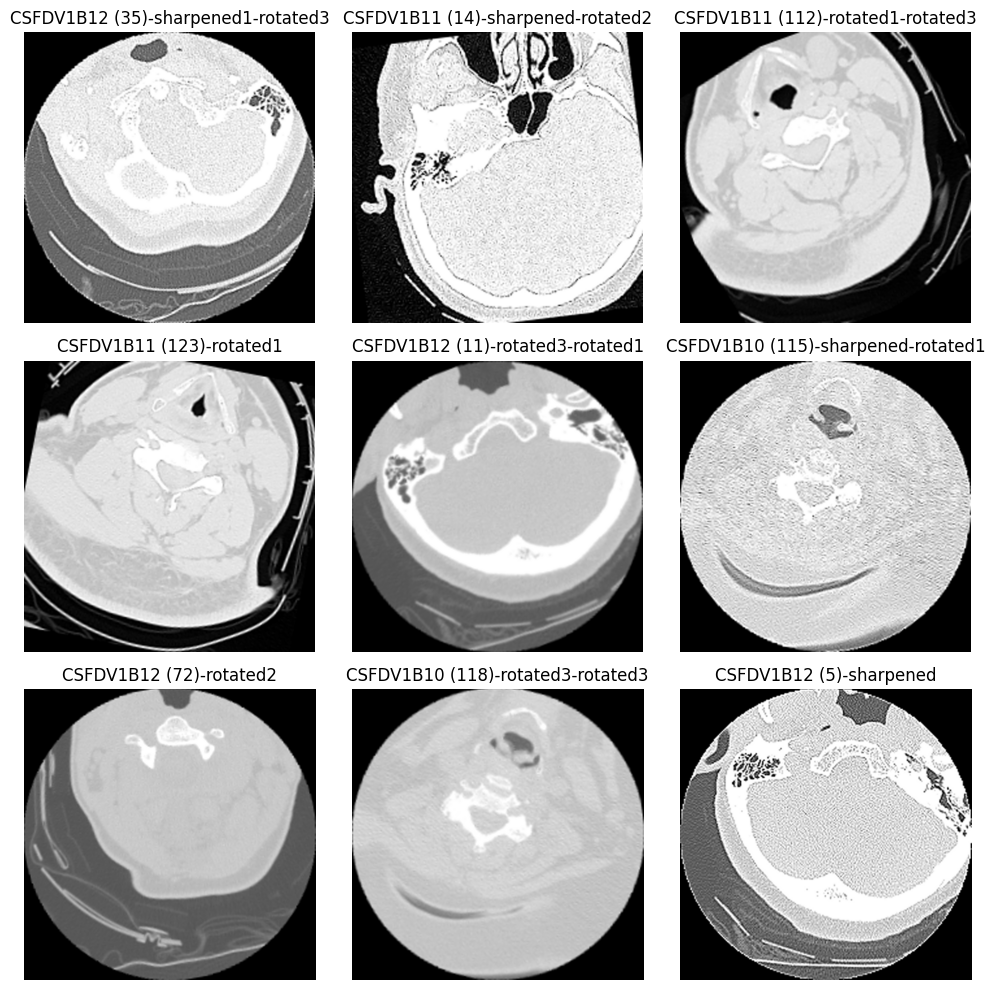

In [19]:
# --- Quick visual sanity check ---
# Randomly sample thumbnails and display them in a grid.
# Great for catching mislabels, corrupt images, or normalization errors.

# imports
import random, matplotlib.pyplot as plt
from pathlib import Path

thumbs = list(THUMBS_DIR.glob("*.png"))
if len(thumbs) == 0:
  print("No thumbnails found. Did you set INDEX_CSV to the right split?")
else:
  sample = random.sample(thumbs, k=min(9, len(thumbs)))

plt.figure(figsize=(10,10))
for i, p in enumerate(sample, 1):
  img = plt.imread(p)
  plt.subplot(3,3,i)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(p.stem)
plt.tight_layout()
plt.show()